# Assignment 4: Graph Neural Networks

Contact: [Abdellah RAHMANI](mailto:abdellah.rahmani@epfl.ch) [Jinhan LIU](mailto:jinhan.liu@epfl.ch)

## Students

* Team: `20`
* Students: `Hugo Fluhr`, `Nino Herve`

## Rules

> ⚠️ **Read carefully before starting**

**Deadline:** May 16th

**Grading:**
* The integrality of Assignment 4 will be scaled to 100% and will amount to 25% of the overall assignments score.
* The total number of points is **40**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Anything outside shall not be touched, except if otherwise stated.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
> **Your answer here:**

**Submission:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

# Objective

The purpose of this assignment is to first understand and explore the building blocks of Graph Neural Networks (GNN), and then try to implement more up-to-date GNN architectures or build up new ones using your own ideas. 

Through these two sections, we hope that you could obtain solid understanding of GNN components and architectures, and gain more experience in solving practical tasks using basic models and then try to improve upon it.

# First part: Understanding Pooling and Graph Convolutional Layers (20 pts)
In the first part, you will try to go through our implementation of a Graph Convolution Network, and discover both the key components and the entire structure of a typical GNN. 

In this section, implementation is not required. Rather, you are requested to execute the various code sections, analyze their outcomes, and provide an explanation of the results. The objective is to understand pooling in graphs and also graph convolutional with spectral filtering. 

# Graph ConvNets in PyTorch

PyTorch implementation of the NeurIPS'16 paper:
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering
M Defferrard, X Bresson, P Vandergheynst
Advances in Neural Information Processing Systems, 3844-3852, 2016
[ArXiv preprint](https://arxiv.org/abs/1606.09375)

## Code:

The code provides a simple example of graph ConvNets for the MNIST classification task.
The graph is a 8-nearest neighbor graph of a 2D grid.
The signals on graph are the MNIST images vectorized as $28^2 \times 1$ vectors.

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import collections
import time
import numpy as np
import scipy
from functools import partial
import os

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

cuda available


# Connect to your drive

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Loading the data

This code is only to load the Mnist data set, you just need to run it

In [3]:
def check_mnist_dataset_exists(path_data='./'):
    flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt') 
    flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt') 
    flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt') 
    flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt') 
    if flag_train_data==False or flag_train_label==False or flag_test_data==False or flag_test_label==False:
        print('MNIST dataset preprocessing...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
                                                download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
                                               download=True, transform=transforms.ToTensor())
        train_data=torch.Tensor(60000,28,28)
        train_label=torch.LongTensor(60000)
        for idx , example in enumerate(trainset):
            train_data[idx]=example[0].squeeze()
            train_label[idx]=example[1]
        torch.save(train_data,path_data + 'mnist/train_data.pt')
        torch.save(train_label,path_data + 'mnist/train_label.pt')
        test_data=torch.Tensor(10000,28,28)
        test_label=torch.LongTensor(10000)
        for idx , example in enumerate(testset):
            test_data[idx]=example[0].squeeze()
            test_label[idx]=example[1]
        torch.save(test_data,path_data + 'mnist/test_data.pt')
        torch.save(test_label,path_data + 'mnist/test_label.pt')
    return path_data


_ = check_mnist_dataset_exists()

In [4]:
#if you want to play with a small dataset (for cpu), uncomment.
#nb_selected_train_data = 500
#nb_selected_test_data = 100

train_data=torch.load('mnist/train_data.pt').reshape(60000,784).numpy()
#train_data = train_data[:nb_selected_train_data,:]
print(train_data.shape)

train_labels=torch.load('mnist/train_label.pt').numpy()
#train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data=torch.load('mnist/test_data.pt').reshape(10000,784).numpy()
#test_data = test_data[:nb_selected_test_data,:]
print(test_data.shape)

test_labels=torch.load('mnist/test_label.pt').numpy()
#test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


Here we construct the graph using the 8-nearest neighbors of a 2D grid using Euclidean distance metrics.

In [5]:
from grid_graph import grid_graph
from coarsening import coarsen, HEM, compute_perm, perm_adjacency
from coarsening import perm_data

# Construct graph
t_start = time.time()
grid_side = 28
number_edges = 8
metric = 'euclidean'


######## YOUR GRAPH ADJACENCY MATRIX HERE ########
A = grid_graph(grid_side,number_edges,metric) # create graph of Euclidean grid
######## YOUR GRAPH ADJACENCY MATRIX HERE ########

nb edges:  6396


In the following two cells we build up functions for calculating the graph Laplacian and retrieving the largest eigenvalue of it with scaling .

In [6]:
def laplacian(W, normalized=True):
    """Return graph Laplacian"""
    I = scipy.sparse.identity(W.shape[0], dtype=W.dtype)

    #W += I
    # Degree matrix.
    d = W.sum(axis=0)
    # Laplacian matrix.
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d_inv = 1/d
        Dinv = scipy.sparse.csr_matrix.sqrt(scipy.sparse.diags(d_inv.A.squeeze(), 0))
        L =  - Dinv.dot(W.dot(Dinv))# i modified this normalization in order to use it in question 5 Lsym  = Lsym-I

        pass

    assert np.abs(L - L.T).mean() < 1e-8
    assert type(L) is scipy.sparse.csr.csr_matrix
    return L

In [7]:
def rescale_L(L, lmax=2):
    """Rescale Laplacian eigenvalues to [-1,1]"""
    M, M = L.shape
    I = scipy.sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax * 2
    L -= I
    return L 

def lmax_L(L):
    """Compute largest Laplacian eigenvalue"""
    return scipy.sparse.linalg.eigsh(L, k=1, which='LM', return_eigenvectors=False)[0]

In the following cells, we can try to implement the graph coarsening with a specific coarsening level and retrieve the corresponding largest eigenvalues of Laplacians of the coarsened graphs. 

In [8]:
# Compute coarsened graphs
coarsening_levels = 4

L, perm = coarsen(A, coarsening_levels, partial(laplacian, normalized=True))

Heavy Edge Matching coarsening with Xavier version
Layer 0: M_0 = |V| = 960 nodes (176 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (77 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 240 nodes (29 added), |E| = 781 edges
Layer 3: M_3 = |V| = 120 nodes (7 added), |E| = 388 edges
Layer 4: M_4 = |V| = 60 nodes (0 added), |E| = 194 edges


<ipython-input-6-d29d56694506>:13: RuntimeWarning: divide by zero encountered in true_divide
  d_inv = 1/d
<ipython-input-6-d29d56694506>:20: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  assert type(L) is scipy.sparse.csr.csr_matrix


In [9]:
# Compute coarsened graphs
coarsening_levels = 4

L, perm = coarsen(A, coarsening_levels, partial(laplacian, normalized=False))

# Compute max eigenvalue of graph Laplacians
lmax = []
for i in range(coarsening_levels):
    lmax.append(lmax_L(L[i]))
print('lmax: ' + str([lmax[i] for i in range(coarsening_levels)]))

# Reindex nodes to satisfy a binary tree structure
train_data = perm_data(train_data, perm)
test_data = perm_data(test_data, perm)

print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm

Heavy Edge Matching coarsening with Xavier version


<ipython-input-6-d29d56694506>:20: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  assert type(L) is scipy.sparse.csr.csr_matrix


Layer 0: M_0 = |V| = 960 nodes (176 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (77 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 240 nodes (29 added), |E| = 781 edges
Layer 3: M_3 = |V| = 120 nodes (7 added), |E| = 388 edges
Layer 4: M_4 = |V| = 60 nodes (0 added), |E| = 194 edges
lmax: [5.87704, 11.296647, 19.596706, 30.225954]
Execution time: 1.56s


Here, we implemented the pooling layers and computed the list `L` containing the Laplacians of the graphs for each layer.

## <font color='red'>Question 1: what is the size of the various poolings? (2pts) </font> 

> **Your answer here:**  
The pooling at each coarsening level aggregates two nodes into one. In other words, it is a pooling of size two.

# Graph ConvNet LeNet5

With the components including graph coarsening and graph Laplacian computation, now we can build a entire GNN architecture for the image classification task, such as the classic Graph ConvNet LeNet5, which contains 2 graph convolutional layers, 2 pooling layers with size 4 and two fully-connected layers as shown below:

1. Convolutional layer (Dim=32)
2. Max pooling layer (Dim=4)
3. Convolutional layer (Dim=64)
4. Max pooling layer (Dim=4)
5. Fully-connected layer (Dim=512)
6. Fully-connected layer (Dim=10)

## <font color='red'>Question 2: which graphs will you take in the list `L` for the graph convolutional layers? (2pts)</font> 



> **Your answer here:**  
The first convolution uses the original graph's Laplacian, corresponding to the first Laplacian in the list L (L[0]). Then we have a pooling of size 4, which is equivalent to pooling twice with size 2. So the second convolution uses the Laplacian of the graph that has been aggregated twice, which is the third element in list L (L[2]). We will use L[0] and L[2].


Let's define a torch class of GNN module and initialize our Graph ConvNet LeNet5 using its network parameter settings.

In [10]:
class Graph_ConvNet_LeNet5(nn.Module):
    
    def __init__(self, net_parameters, rescale = True):
        
        print('Graph ConvNet: LeNet5')
        
        super(Graph_ConvNet_LeNet5, self).__init__()
        
        # parameters
        self.rescale = rescale
        D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F = net_parameters
        FC1Fin = CL2_F*(D//16)
        
        # graph CL1
        self.cl1 = nn.Linear(CL1_K, CL1_F) 
        self.init_layers(self.cl1, CL1_K, CL1_F)
        self.CL1_K = CL1_K; self.CL1_F = CL1_F; 
        
        # graph CL2
        self.cl2 = nn.Linear(CL2_K*CL1_F, CL2_F) 
        self.init_layers(self.cl2, CL2_K*CL1_F, CL2_F)
        self.CL2_K = CL2_K; self.CL2_F = CL2_F; 

        # FC1
        self.fc1 = nn.Linear(FC1Fin, FC1_F) 
        self.init_layers(self.fc1, FC1Fin, FC1_F)
        self.FC1Fin = FC1Fin
        
        # FC2
        self.fc2 = nn.Linear(FC1_F, FC2_F)
        self.init_layers(self.fc2, FC1_F, FC2_F)

        # nb of parameters
        nb_param = CL1_K* CL1_F + CL1_F          # CL1
        nb_param += CL2_K* CL1_F* CL2_F + CL2_F  # CL2
        nb_param += FC1Fin* FC1_F + FC1_F        # FC1
        nb_param += FC1_F* FC2_F + FC2_F         # FC2
        print('nb of parameters=',nb_param,'\n')
        
        
    def init_layers(self, W, Fin, Fout):

        scale = np.sqrt( 2.0/ (Fin+Fout) )
        W.weight.data.uniform_(-scale, scale)
        W.bias.data.fill_(0.0)

        return W
        
        
    def graph_conv_cheby(self, x, cl, L, lmax, Fout, K):
        # parameters
        # B = batch size
        # V = nb vertices
        # Fin = nb input features
        # Fout = nb output features
        # K = Chebyshev order & support size
        B, V, Fin = x.size(); B, V, Fin = int(B), int(V), int(Fin) 

        # rescale Laplacian
        lmax = lmax_L(L)
        if self.rescale:
          
          L = rescale_L(L, lmax) 
        
        # convert scipy sparse matric L to pytorch
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col)).T 
        indices = indices.astype(np.int64)
        indices = torch.from_numpy(indices)
        indices = indices.type(torch.LongTensor)
        L_data = L.data.astype(np.float32)
        L_data = torch.from_numpy(L_data) 
        L_data = L_data.type(torch.FloatTensor)
        L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
        L.requires_grad_(False)
        if torch.cuda.is_available():
            L = L.cuda()
        # transform to Chebyshev basis
        x0 = x.permute(1,2,0).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])            # V x Fin*B
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B
        
        def concat(x, x_):
            x_ = x_.unsqueeze(0)            # 1 x V x Fin*B
            return torch.cat((x, x_), 0)    # K x V x Fin*B  
             
        if K > 1: 
            x1 = torch.mm(L,x0)              # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)),0)  # 2 x V x Fin*B
        for k in range(2, K):
            x2 = 2 * torch.mm(L,x1) - x0  
            x = torch.cat((x, x2.unsqueeze(0)),0)  # M x Fin*B
            x0, x1 = x1, x2  
        
        x = x.view([K, V, Fin, B])           # K x V x Fin x B     
        x = x.permute(3,1,2,0).contiguous()  # B x V x Fin x K       
        x = x.view([B*V, Fin*K])             # B*V x Fin*K
        
        # Compose linearly Fin features to get Fout features
        x = cl(x)                            # B*V x Fout  
        x = x.view([B, V, Fout])             # B x V x Fout
        return x
        
        
    # Max pooling of size p. Must be a power of 2.
    def graph_max_pool(self, x, p): 
        if p > 1: 
            x = x.permute(0,2,1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)             # B x F x V/p          
            x = x.permute(0,2,1).contiguous()  # x = B x V/p x F
            return x  
        else:
            return x   
        
        
    def forward(self, x, d, L, lmax):
        # graph CL1
        x = x.unsqueeze(2) # B x V x Fin=1  
        x = self.graph_conv_cheby(x, self.cl1, L[0], lmax[0], self.CL1_F, self.CL1_K)
        x = F.relu(x)
        x = self.graph_max_pool(x, 4)
        # graph CL2
        x = self.graph_conv_cheby(x, self.cl2, L[2], lmax[2], self.CL2_F, self.CL2_K)
        x = F.relu(x)
        x = self.graph_max_pool(x, 4)
        # FC1
        x = x.view(-1, self.FC1Fin)
        x = self.fc1(x)
        x = F.relu(x)
        x  = nn.Dropout(d)(x)
        # FC2
        x = self.fc2(x)
        return x
        
        
    def loss(self, y, y_target, l2_regularization):
    
        loss = nn.CrossEntropyLoss()(y,y_target)

        l2_loss = 0.0
        for param in self.parameters():
            data = param* param
            l2_loss += data.sum()
           
        loss += 0.5* l2_regularization* l2_loss
            
        return loss
    
    
    def update(self, lr):
                
        update = torch.optim.SGD( self.parameters(), lr=lr, momentum=0.9 )
        
        return update
        
        
    def update_learning_rate(self, optimizer, lr):
   
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        return optimizer

    
    def evaluation(self, y_predicted, test_l):
    
        _, class_predicted = torch.max(y_predicted.data, 1)
        return 100.0* (class_predicted == test_l).sum()/ y_predicted.size(0)

In [11]:
# Delete existing network if exists
try:
    del net
    print('Delete existing network\n')
except NameError:
    print('No existing network to delete\n')

# network parameters
D = train_data.shape[1]
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]
dropout_value = 0.5

# instantiate the object net of the class 
net = Graph_ConvNet_LeNet5(net_parameters)
if torch.cuda.is_available():
    net.cuda()
print(net)

No existing network to delete

Graph ConvNet: LeNet5
nb of parameters= 2023818 

Graph_ConvNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3840, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Good time, to check the network is working. Now we can partition the dataset and evaluate our GNN upon it.

In [12]:
train_x, train_y = train_data[:5,:], train_labels[:5]
train_x =  torch.FloatTensor(train_x).type(dtypeFloat)
train_y = train_y.astype(np.int64)
train_y = torch.LongTensor(train_y).type(dtypeLong) 
            
# Forward 
y = net(train_x, dropout_value, L, lmax)
print(y.shape)

torch.Size([5, 10])


In [13]:
# Weights
L_net = list(net.parameters())

# learning parameters
learning_rate = 0.05
l2_regularization = 5e-4 
batch_size = 100
num_epochs = 3
train_size = train_data.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs=',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)

# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 

# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:], train_labels[batch_idx]
        train_x =  torch.FloatTensor(train_x).type(dtypeFloat)
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong) 
            
        # Forward 
        y = net(train_x, dropout_value, L, lmax)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.detach().item()
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        # backward
        loss.backward()
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        # print        
        if not running_total%100: # print every x mini-batches
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 
    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    with torch.no_grad():
        running_accuray_test = 0
        running_total_test = 0
        indices_test = collections.deque()
        indices_test.extend(range(test_data.shape[0]))
        t_start_test = time.time()
        while len(indices_test) >= batch_size:
            batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
            test_x, test_y = test_data[batch_idx_test,:], test_labels[batch_idx_test]
            test_x = torch.FloatTensor(test_x).type(dtypeFloat)
            y = net(test_x, 0.0, L, lmax) 
            test_y = test_y.astype(np.int64)
            test_y = torch.LongTensor(test_y).type(dtypeLong)
            acc_test = net.evaluation(y,test_y.data)
            running_accuray_test += acc_test
            running_total_test += 1
        t_stop_test = time.time() - t_start_test
        print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))

num_epochs= 3 , train_size= 60000 , nb_iter= 1800
epoch= 1, i=  100, loss(batch)= 0.4104, accuray(batch)= 89.00
epoch= 1, i=  200, loss(batch)= 0.2916, accuray(batch)= 94.00
epoch= 1, i=  300, loss(batch)= 0.2633, accuray(batch)= 97.00
epoch= 1, i=  400, loss(batch)= 0.1679, accuray(batch)= 98.00
epoch= 1, i=  500, loss(batch)= 0.2145, accuray(batch)= 94.00
epoch= 1, i=  600, loss(batch)= 0.2025, accuray(batch)= 97.00
epoch= 1, loss(train)= 0.373, accuracy(train)= 91.520, time= 76.931, lr= 0.05000
  accuracy(test) = 97.950 %, time= 8.806
epoch= 2, i=  100, loss(batch)= 0.1388, accuray(batch)= 100.00
epoch= 2, i=  200, loss(batch)= 0.1418, accuray(batch)= 99.00
epoch= 2, i=  300, loss(batch)= 0.1647, accuray(batch)= 98.00
epoch= 2, i=  400, loss(batch)= 0.1775, accuray(batch)= 98.00
epoch= 2, i=  500, loss(batch)= 0.1755, accuray(batch)= 99.00
epoch= 2, i=  600, loss(batch)= 0.1474, accuray(batch)= 98.00
epoch= 2, loss(train)= 0.179, accuracy(train)= 97.653, time= 66.244, lr= 0.04750
  

### <font color='red'>Question 3: In this code, each convolutional layer has a parameter K. What does it represent? What are the consequences of choosing a higher or lower value of K? (4pts)</font> 

> **Your answer here:**  
K represents the highest index of the Chebyshev polynomials. In our context, Chebyshev polynomials are filter elements, each being a polynomial of the Laplacian with degree K. Due to the Laplacian's properties, each filter represented by Kth order polynomials contains information from a k-hops field of view. Consequently, the K parameter makes the filter K-localized. 
Lower values of K decrease the field of view of the filter, leveraging closely localized information. In contrast, higher values of k increase the field of view, generating global information on the graph. Computing more polynomials (higher K) will also result in more computations.



### <font color='red'>Question 4: Is it necessary to rescale the Laplacian (in the function `rescale_L`)? (4pts) Try to remove it and explain what happens. </font> 

Hint: See Section 2.1 of [the paper](https://arxiv.org/pdf/1606.09375.pdf).


In [14]:
# Delete existing network if exists
try:
    del net
    print('Delete existing network\n')
except NameError:
    print('No existing network to delete\n')

# network parameters
D = train_data.shape[1]
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]
dropout_value = 0.5

# instantiate the object net of the class, !!! we removed the rescale
net = Graph_ConvNet_LeNet5(net_parameters, rescale = False)
if torch.cuda.is_available():
    net.cuda()
print(net)

Delete existing network

Graph ConvNet: LeNet5
nb of parameters= 2023818 

Graph_ConvNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3840, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [15]:
# Compute coarsened graphs
coarsening_levels = 4

L, perm = coarsen(A, coarsening_levels, partial(laplacian, normalized=False))

# Compute max eigenvalue of graph Laplacians
lmax = []
for i in range(coarsening_levels):
    lmax.append(lmax_L(L[i]))
print('lmax: ' + str([lmax[i] for i in range(coarsening_levels)]))

# Reindex nodes to satisfy a binary tree structure
train_data = perm_data(train_data, perm)
test_data = perm_data(test_data, perm)

print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm

Heavy Edge Matching coarsening with Xavier version
Layer 0: M_0 = |V| = 960 nodes (176 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 480 nodes (77 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 240 nodes (29 added), |E| = 781 edges
Layer 3: M_3 = |V| = 120 nodes (7 added), |E| = 388 edges
Layer 4: M_4 = |V| = 60 nodes (0 added), |E| = 194 edges
lmax: [5.8770437, 11.296648, 19.596704, 30.225956]


<ipython-input-6-d29d56694506>:20: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  assert type(L) is scipy.sparse.csr.csr_matrix


Execution time: 75.78s


In [16]:
# Weights
L_net = list(net.parameters())

# learning parameters
learning_rate = 0.05
l2_regularization = 5e-4 
batch_size = 100
num_epochs = 3
train_size = train_data.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs=',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)

# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 

# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:], train_labels[batch_idx]
        train_x =  torch.FloatTensor(train_x).type(dtypeFloat)
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong) 
            
        # Forward 
        y = net(train_x, dropout_value, L, lmax)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.detach().item()
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        # backward
        loss.backward()
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        # print        
        if not running_total%100: # print every x mini-batches
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 
    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    with torch.no_grad():
        running_accuray_test = 0
        running_total_test = 0
        indices_test = collections.deque()
        indices_test.extend(range(test_data.shape[0]))
        t_start_test = time.time()
        while len(indices_test) >= batch_size:
            batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
            test_x, test_y = test_data[batch_idx_test,:], test_labels[batch_idx_test]
            test_x = torch.FloatTensor(test_x).type(dtypeFloat)
            y = net(test_x, 0.0, L, lmax) 
            test_y = test_y.astype(np.int64)
            test_y = torch.LongTensor(test_y).type(dtypeLong)
            acc_test = net.evaluation(y,test_y.data)
            running_accuray_test += acc_test
            running_total_test += 1
        t_stop_test = time.time() - t_start_test
        print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))

num_epochs= 3 , train_size= 60000 , nb_iter= 1800
epoch= 1, i=  100, loss(batch)= nan, accuray(batch)= 12.00
epoch= 1, i=  200, loss(batch)= nan, accuray(batch)= 9.00
epoch= 1, i=  300, loss(batch)= nan, accuray(batch)= 9.00
epoch= 1, i=  400, loss(batch)= nan, accuray(batch)= 11.00
epoch= 1, i=  500, loss(batch)= nan, accuray(batch)= 10.00
epoch= 1, i=  600, loss(batch)= nan, accuray(batch)= 10.00
epoch= 1, loss(train)= nan, accuracy(train)= 9.872, time= 66.948, lr= 0.05000
  accuracy(test) = 9.800 %, time= 6.601
epoch= 2, i=  100, loss(batch)= nan, accuray(batch)= 13.00
epoch= 2, i=  200, loss(batch)= nan, accuray(batch)= 8.00
epoch= 2, i=  300, loss(batch)= nan, accuray(batch)= 7.00
epoch= 2, i=  400, loss(batch)= nan, accuray(batch)= 12.00
epoch= 2, i=  500, loss(batch)= nan, accuray(batch)= 11.00
epoch= 2, i=  600, loss(batch)= nan, accuray(batch)= 8.00
epoch= 2, loss(train)= nan, accuracy(train)= 9.872, time= 66.527, lr= 0.04750
  accuracy(test) = 9.800 %, time= 6.768
epoch= 3, i

> **Your answer here:**  
The loss is not a number and thus the model does not train. This is due to the Laplacian eigenvalues being unbounded ($\lambda_i>1$), as powers of the eigenvalues are used in the computation of the Chebyshev polynomials, they need to be smaller or equal to 1 for it to be stable.


### <font color='red'>Question 5: Is it possible to modify the Laplacian to avoid the rescaling step? (3pts)</font> 

Hint: Think about the eigenvalues of the Laplacian and how to normalize them.

> **Your answer here:**  
Another way to achieve bounded eigenvalues without rescaling is to use a modified version of the normalized graph Laplacian. Indeed the normalized Laplacian $ L_n = I - D^{-1/2}WD^{-1/2} $ has eigenvalues smaller or equal to 2. If we subtract the $I$ from this normalized Laplacian, which becomes $ \tilde{L_n} = - D^{-1/2}WD^{-1/2} $, we thus obtain eigenvalues smaller or equal to 1 without needing to rescale. When we try to run the above code with this modified normalized Laplacian, the loss is a number and the model does train.

### <font color='red'>Question 6: Which of the following choice is true? (3pts)</font> 
* (A) The presented GCN will be a message passing GNN for K=1
* (B) The presented GCN will be a message passing GNN for any value of K
* (C) No, it could never be a layer of message passing GNN

Explain your answer.



> **Your answer here:**  
Message passing is always exchanging information between neighboring nodes, it thus corresponds to K=1 (1-hop neighbors) GCNs with no pooling and coarsening of the graph.  Multiple layers can be added to exchange information with neighbors of neighbors etc.


### <font color='red'> Question 7: In which cases do you expect: (2pts)</font> 
* a Graph CNN to work better than a CNN?
* a CNN to work better than a Graph CNN?

For the MNIST classification problem, is there an advantage in using a Graph CNN instead of CNN ? Explain. 

> **Your answer here:**  
Graph CNN is valuable when the data lives on a graph that captures meaningful relationships between the nodes. For an image, the grid graph is regular and thus it is not necessary to use a Graph CNN as convolution on the image already exploits the pixel neighborhood structure. This means that CNN is probably a better choice for the MNIST classification problem as it is a simpler architecture better suited for the image setting. 
We would expect a GNN to work better in cases where the relationships between the nodes are irregular, thus taking advantage of the graph structure of the data.

# Second section: Practical Session on Graph Neural Networks:

## Objective:
In the second part, you will work on a different Protein-Protein Network graph dataset, and try to defeat the baseline model by either implementing state-of-the-art GNN architectures, or possibly using your own ideas based on the task and the graph structures of this dataset. This section may guide you how you can take advantage of GNN on any unknown task or dataset in the future.


##<font color='red'> **PART 1 : CODING** (8pts)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [17]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [18]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node contains:
- 50 features : e.g., positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

In [19]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model
Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features which is the number of classes.

In [20]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [21]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next, a function is designed to evaluate the performance of the model, computing the F1-Score.

In [22]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [23]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6363
F1-Score: 0.4550
Epoch 00002 | Loss: 0.5798
Epoch 00003 | Loss: 0.5619
Epoch 00004 | Loss: 0.5558
Epoch 00005 | Loss: 0.5508
Epoch 00006 | Loss: 0.5466
F1-Score: 0.4955
Epoch 00007 | Loss: 0.5422
Epoch 00008 | Loss: 0.5377
Epoch 00009 | Loss: 0.5344
Epoch 00010 | Loss: 0.5319
Epoch 00011 | Loss: 0.5291
F1-Score: 0.5274
Epoch 00012 | Loss: 0.5265
Epoch 00013 | Loss: 0.5240
Epoch 00014 | Loss: 0.5217
Epoch 00015 | Loss: 0.5195
Epoch 00016 | Loss: 0.5174
F1-Score: 0.5296
Epoch 00017 | Loss: 0.5154
Epoch 00018 | Loss: 0.5134
Epoch 00019 | Loss: 0.5113
Epoch 00020 | Loss: 0.5091
Epoch 00021 | Loss: 0.5066
F1-Score: 0.5149
Epoch 00022 | Loss: 0.5044
Epoch 00023 | Loss: 0.5025
Epoch 00024 | Loss: 0.5008
Epoch 00025 | Loss: 0.4987
Epoch 00026 | Loss: 0.4970
F1-Score: 0.5422
Epoch 00027 | Loss: 0.4952
Epoch 00028 | Loss: 0.4934
Epoch 00029 | Loss: 0.4915
Epoch 00030 | Loss: 0.4897
Epoch 00031 | Loss: 0.4880
F1-Score: 0.5511
Epoch 00032 | Loss: 0.4862
Ep

Basic Model : F1-Score on the test set: 0.6753


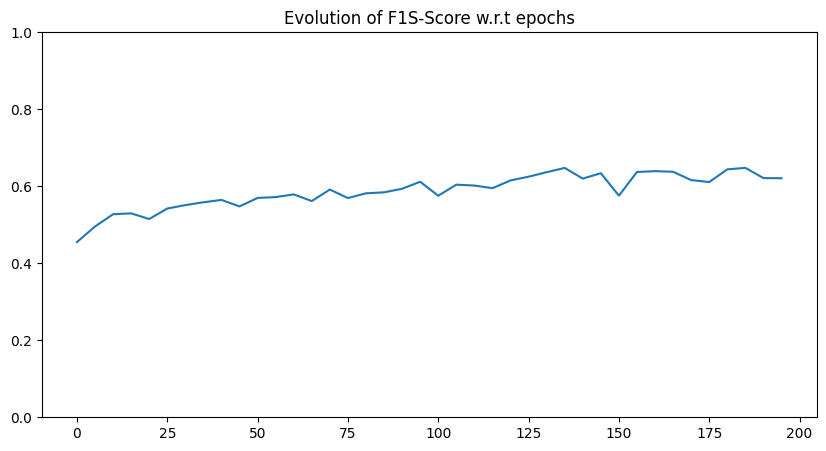

In [24]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### <font color='red'> Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells. You can either use the architectures you learned from the lecture, or try to come up with an idea of your own.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [29]:
# Your solution here ###########################################################

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
class StudentModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, head1, head2, head3):
      super().__init__()
      
      ####### YOUR ANSWER #######
      self.graphconv1 = graphnn.GATConv(input_size, hidden_size, head1)
      self.graphconv2 = graphnn.GATConv(hidden_size*head1, hidden_size, head2)
      self.graphconv3 = graphnn.GATConv(hidden_size*head2, output_size, head3, 
                                        concat=False)
      
      self.elu = nn.ELU()

  def forward(self, x, edge_index):

      ####### YOUR ANSWER #######
      x = self.graphconv1(x, edge_index)
      x = self.elu(x)
      x = self.graphconv2(x, edge_index)
      x = self.elu(x)
      x = self.graphconv3(x, edge_index)

      return x

In [30]:
## Student model
student_model = StudentModel(input_size = n_features, 
                             hidden_size = 256, 
                             output_size = n_classes,
                             head1 = 4, head2 = 4, head3 = 6).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.6916
F1-Score: 0.4048
Epoch 00002 | Loss: 0.5654
Epoch 00003 | Loss: 0.5417
Epoch 00004 | Loss: 0.5340
Epoch 00005 | Loss: 0.5181
Epoch 00006 | Loss: 0.5105
F1-Score: 0.4920
Epoch 00007 | Loss: 0.5033
Epoch 00008 | Loss: 0.5001
Epoch 00009 | Loss: 0.4972
Epoch 00010 | Loss: 0.4909
Epoch 00011 | Loss: 0.4824
F1-Score: 0.5342
Epoch 00012 | Loss: 0.4773
Epoch 00013 | Loss: 0.4766
Epoch 00014 | Loss: 0.4723
Epoch 00015 | Loss: 0.4636
Epoch 00016 | Loss: 0.4606
F1-Score: 0.5845
Epoch 00017 | Loss: 0.4558
Epoch 00018 | Loss: 0.4493
Epoch 00019 | Loss: 0.4435
Epoch 00020 | Loss: 0.4386
Epoch 00021 | Loss: 0.4359
F1-Score: 0.6090
Epoch 00022 | Loss: 0.4417
Epoch 00023 | Loss: 0.4355
Epoch 00024 | Loss: 0.4267
Epoch 00025 | Loss: 0.4181
Epoch 00026 | Loss: 0.4164
F1-Score: 0.6133
Epoch 00027 | Loss: 0.4076
Epoch 00028 | Loss: 0.4016
Epoch 00029 | Loss: 0.3975
Epoch 00030 | Loss: 0.3909
Epoch 00031 | Loss: 0.3936
F1-Score: 0.6332
Epoch 00032 | Loss: 0.3855
Epoch 00033 | Los

Student Model : F1-Score on the test set: 0.9279


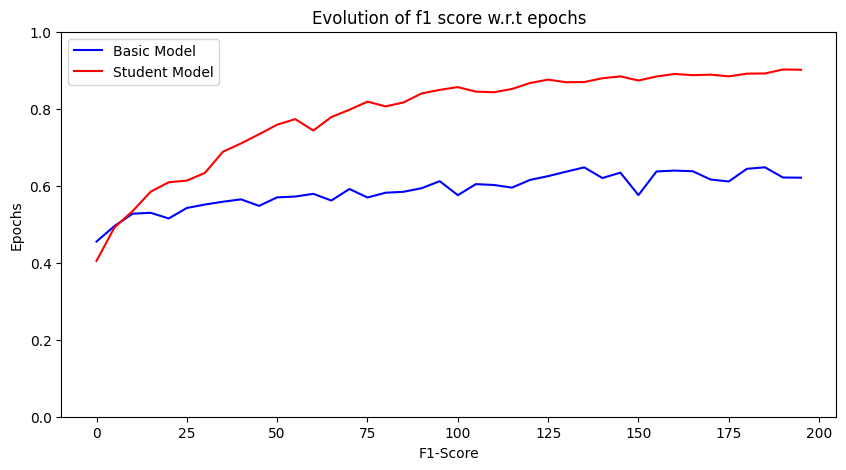

In [31]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## <font color='red'> **PART 2 : QUESTIONS** (12pts)


<font color='red'> 1. Explains your achitecture and justifies your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).

> **Your answer here:**  
We chose to replicate the architecture from the original GAT paper linked in the notebook. Indeed they apply their new method to the same PPI dataset so it seemed valid to use the same architecture. The key difference between this model and the GCN-based model is what is called the attention in each layer. The attention is the relative importance of each node to each other, this parameter is also trained which means that it is optimized.  
Instead of a GCN layer in which the same value is attributed to the information coming from neighboring nodes, the GAT considers that the network should be more general by learning which neighbors are more/less important when exchanging information. This is the attention mechanism in GATs and we indeed see that the performance is much better than with the GCN model.


<font color='red'>  2. Analyses your results (what is the F1-Score ? are your results convincing ?)

> **Your answer here:**  
The F1-score is a standard measure of performance for classification tasks, it is a ratio of precision and recall. In our case we see that the GAT based model achieves an F1-score of over $90\%$ which is very convincing as it is much higher than the $\approx 60-65\%$ of the GCN based model.

<font color='red'> 3. Provide a diagram of your architecture, which includes a good and clear legend as well as shapes information. The diagram must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted).

> **Your answer here:**

<font color='red'> 4. What is the name of the problem that arises when using deep GNNs? Define and explain this problem.

> **Your answer here:**  
The problem is called over-smoothing: As the model gets deeper, the information of the whole graph is shared with everyone, and hence node features become similar everywhere.

<font color='red'> 5. Are there solutions to overcome it ? 

> **Your answer here:**  
One current way to alleviate over-smoothing is to train while randomly dropping edges, as it is done using DropEdge (Rong et al. 2020), Adaptive Connection Sampling (Hasanzadesh et al. 2020) and Neural Sparsification (Zheng et al. 2020).
By removing some edges, the model is forced to rely on a more limited set of neighbors for each node, reducing information flow from distant nodes.
